# Code to reproduce the figures in Chapter 'Coordinate-based multi-layer perceptrons'

In [1]:
import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Compose, ToTensor, Normalize, CenterCrop, Grayscale
import numpy as np
import matplotlib.pyplot as plt
import imageio

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '3'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


## Define the coordinate-based network architectures

In [2]:
class FourierFeatureMap(nn.Module):    
    def __init__(self, in_features, out_features,scale=30, sigma=10,requires_grad=False,bias=False,init="normal"):
        super().__init__()
        self.scale = scale
        self.sigma = sigma
        self.init = init      
        self.out_features = out_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()
        self.linear.weight.requires_grad = requires_grad
        if bias:
            self.linear.bias.requires_grad = requires_grad
    
    def init_weights(self):
        with torch.no_grad():
            if self.init=="normal":
                self.linear.weight.normal_(std=self.sigma)
                if self.linear.bias is not None:
                    self.linear.bias.normal_(std=self.sigma)
            else:
                self.linear.weight.uniform_(-self.sigma,self.sigma)
                if self.linear.bias is not None:
                    self.linear.bias.uniform_(-self.sigma,self.sigma)

    def forward(self, input):
        return torch.cat( ( 1/np.sqrt(self.out_features)*torch.sin(self.scale*self.linear(input)), 
                            1/np.sqrt(self.out_features)*torch.cos(self.scale*self.linear(input)) ) , len(input.shape)-1 )
     

class ReluLayer(nn.Module):    
    def __init__(self, in_features, out_features,scale=1, sigma=1,normalize=False):
        super().__init__()
        self.scale = scale
        self.sigma = sigma
        self.out_features = out_features
        self.linear = nn.Linear(in_features, out_features, bias=True)
        self.init_weights()
        self.normalize=normalize
    
    def init_weights(self):
        with torch.no_grad():
            self.linear.weight.normal_(std=self.sigma)
            if self.linear.bias is not None:
                self.linear.bias.normal_(std=0.000001)

    def forward(self, input):
        if self.normalize==False:
            return np.sqrt(2/self.out_features) * torch.relu(self.scale*self.linear(input))
        else:
            tmp = np.sqrt(2/self.out_features) * torch.nn.functional.relu6(self.scale*self.linear(input))
            scale = ( 1/( torch.std(tmp, unbiased=False,dim=-1) + 1e-5) )[:,:,None]
            mean = torch.mean(tmp,dim=-1)[:,:,None]
            return (tmp-mean)*scale
        
# MLP
class FMLP(nn.Module):
    def __init__(self, in_features, width, hidden_layers, out_features, bias=False,
                scale=30.0,sigma=1.0,#sigma=0.03/30,
                 final_sigma=0.01,act='fmap',
                 first_layer_trainable=False,first_layer_fmap=True,normalizerelu=True):
        super().__init__()
        
        self.net = []
        
        if first_layer_fmap:
            self.net.append(FourierFeatureMap(in_features, width//2,scale=scale, sigma=1/in_features, requires_grad=first_layer_trainable) )
        else:
            self.net.append(ReluLayer(in_features, width, scale=scale))        
        
        for i in range(hidden_layers):
            if act=='fmap':
                self.net.append(FourierFeatureMap(width, width//2, scale=1,sigma=1, requires_grad=True,init="normal",bias=bias) )        
            else:
                self.net.append( ReluLayer(width, width, scale=1,sigma=sigma,normalize=normalizerelu) )
               
        final_linear = nn.Linear(width, out_features, bias=True)
        with torch.no_grad():
            final_linear.weight.normal_(std=final_sigma)
            final_linear.bias.normal_(std=0.00001)
   
        self.net.append(final_linear)
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

## Functions for fitting an image

In [3]:
def get_mgrid(xlen,ylen):
    '''
    Generates a flattened grid of (x,y) coordinates in a range of -1 to 1.
    xlen,ylen: int
    '''
    x = torch.linspace(-1, 1, steps=xlen)
    y = torch.linspace(-1, 1, steps=ylen)
    mgrid = torch.stack(torch.meshgrid(x,y), dim=-1)
    mgrid = mgrid.reshape(-1, 2)
    return mgrid


In [4]:
class ImageFitting(Dataset):
    # img: tensor of shape (nchannels, img_width, img_height)
    def __init__(self, img):
        super().__init__()
        self.nchannels = img.shape[0]        
        self.pixels = img.permute(1, 2, 0).contiguous().view(-1, self.nchannels)        
        self.coords = get_mgrid(img.shape[1],img.shape[2])

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
        return self.coords, self.pixels

The pixel coordinates are 2D, thus the network has two input features, and since the image is grayscale, it has one output channel. The pixel coordinates are in [-1,1] and lie on a equaly spaced grid in [-1,1] x [-1,1].

In [5]:
def fit_mlp(signal,model_input,model,total_steps = 1000,lr=1e-4):
    losses = []
    optim = torch.optim.Adam(lr=lr, params=model.parameters())

    for step in range(total_steps):
        model(model_input)
        model_output, coords = model(model_input)    
        loss = ((model_output - signal)**2).mean()
        losses += [loss.data]
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    return losses,model

# Experiments

In [6]:
def run_exp(signal,model_input,model,total_steps=1000,lr=5e-2,img_width=512,img_height=512):
    frac = sum([np.prod(p.size()) for p in model.parameters() if p.requires_grad==True ]) / np.prod(signal.shape)   
    print("Fraction of trainable parameters of the model over the signal size:",frac)

    losses,model = fit_mlp(signal,model_input,model,total_steps=total_steps,lr=lr)
    out, coords = model(model_input)    

    psnrs = 10.*np.log(2**2/np.array( [loss.cpu() for loss in losses] ))/np.log(10.)
    plt.plot(psnrs)
    plt.show()
    
    img_rec = out.cpu().view(img_height,img_width).detach().numpy()
    img_rec = (img_rec + 1)/2
    
    return psnrs,img_rec


def savemtx_for_logplot(A,filename = "exp.dat"):
    ind = sorted(list(set([int(i) for i in np.geomspace(1, len(A[0])-1 ,num=700)])))
    A = [ [a[i] for i in ind]  for a in A]
    X = np.array([ind] + A)
    np.savetxt(filename, X.T, delimiter=' ')
    
def save_np_img(img,filename):
    if(img.shape[0] == 1):
        plt.imshow(img[0],cmap='gray')
    else:
        plt.imshow(img.transpose(1, 2, 0))
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight')
    plt.close()

def run_example(filename="./data/00011_TE_1744x1160.png",
                outfilename="imgname",
                width=256,
                scale_lr = 1.0,
                permute=False,
                img_width=512,
                img_height=512,
               ):
    
    # load the image
    img = Image.fromarray( imageio.imread(filename) )    
    transformimg = Compose([
        CenterCrop(img_width),
        Grayscale(),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5])),
    ])
    # center crop to 512x512, transform to tensor, normalize to [-1,1]
    img = transformimg(img)
    img_rep = ImageFitting(img)
    
    dataloader = DataLoader(img_rep, batch_size=1, pin_memory=True, num_workers=0)
    model_input, signal = next(iter(dataloader))
    model_input, signal = model_input.cuda(), signal.cuda()

    print(signal.shape)
    if permute:
        signal = signal[:, np.random.permutation(signal.shape[1]) , :]
    img = signal.cpu().view(img_width,img_width).detach().numpy()
    plt.imshow( img ,cmap='gray')
    plt.show()
    save_np_img(img[None,:],outfilename+"orig.jpeg")
    
    model = FMLP(in_features=2,out_features=1,hidden_layers=3,width=width).cuda()
    fmlp_psnrs,img_fmlp = run_exp(signal,model_input,model,total_steps=total_steps,lr=scale_lr*3e-2,img_width=img_width,img_height=img_height)

    model = FMLP(in_features=2,out_features=1,hidden_layers=3,width=int(width/np.sqrt(2)/2)*2,bias=False,
             act="relu",sigma=1.0,final_sigma=.01,normalizerelu=True).cuda()
    fmlprelu_psnrs,img_fmlprelu = run_exp(signal,model_input,model,total_steps=total_steps,lr=scale_lr*1e-2,img_width=img_width,img_height=img_height)

    model = FMLP(in_features=2,out_features=1,hidden_layers=3,bias=True,width=int(width/np.sqrt(2)/2)*2,
             first_layer_fmap=False,act="relu",final_sigma=.001).cuda()
    relu_psnrs,img_relu = run_exp(signal,model_input,model,total_steps=total_steps,lr=scale_lr*5e-4,img_width=img_width,img_height=img_height)

    model = FMLP(in_features=2,out_features=1,hidden_layers=3,width=int(width/np.sqrt(2)/2)*2,
             act="relu",final_sigma=.125,normalizerelu=False).cuda()
    fmlprelunn_psnrs,img_frelunn = run_exp(signal,model_input,model,total_steps=total_steps,lr=scale_lr*1e-2,img_width=img_width,img_height=img_height)

    plt.plot(relu_psnrs,label="relu")
    plt.plot(fmlprelunn_psnrs,label="F relu nn")
    plt.plot(fmlprelu_psnrs,label="F relu")
    plt.plot(fmlp_psnrs,label="F")
    plt.legend()
    plt.show()
    
    # save imgs
    save_np_img(img_fmlp[None,:],outfilename+"_fmap.jpeg")
    save_np_img(img_fmlprelu[None,:],outfilename+"_frelu.jpeg")
    save_np_img(img_relu[None,:],outfilename+"_relu.jpeg")
    save_np_img(img_frelunn[None,:],outfilename+"_frelunn.jpeg")
    
    # save data
    results = [ ]
    for psnrs in [fmlp_psnrs,fmlprelu_psnrs,fmlprelunn_psnrs,relu_psnrs]:
        results += [ psnrs ]
    
    savemtx_for_logplot(results,outfilename+"_fitting.dat")


# First example image

In [7]:
# download the test image
!wget https://jpegai.github.io/public/test_set/00011_TE_1744x1160.png.zip 
!unzip 00011_TE_1744x1160.png.zip

--2023-07-23 11:49:04--  https://jpegai.github.io/public/test_set/00011_TE_1744x1160.png.zip
Resolving jpegai.github.io (jpegai.github.io)... 185.199.110.153, 185.199.108.153, 185.199.109.153, ...
Connecting to jpegai.github.io (jpegai.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4052343 (3.9M) [application/zip]
Saving to: ‘00011_TE_1744x1160.png.zip.2’

00011_TE_1744x1160. 100%[===================>]   3.86M  --.-KB/s    in 0.07s   

2023-07-23 11:49:04 (57.7 MB/s) - ‘00011_TE_1744x1160.png.zip.2’ saved [4052343/4052343]

Archive:  00011_TE_1744x1160.png.zip
replace 00011_TE_1744x1160.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


/tmp/ipykernel_1318101/3984689078.py:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = Image.fromarray( imageio.imread(filename) )
/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 262144, 1])


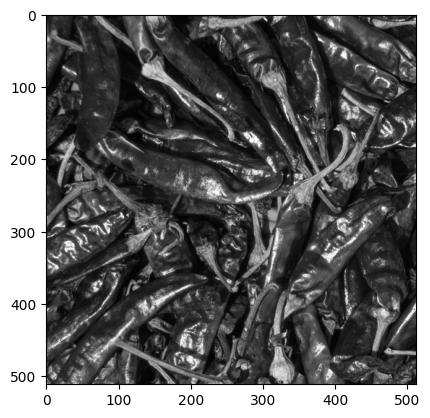

Fraction of trainable parameters of the model over the signal size: 0.3759803771972656


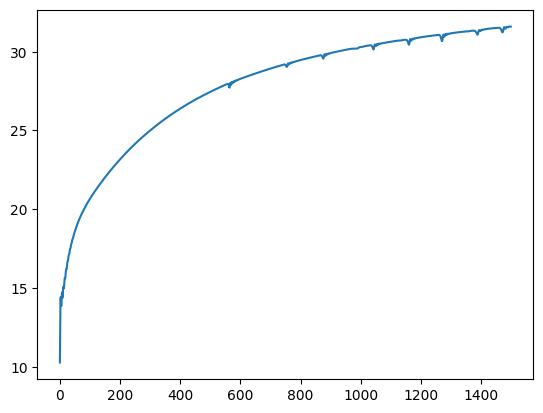

Fraction of trainable parameters of the model over the signal size: 0.3735389709472656


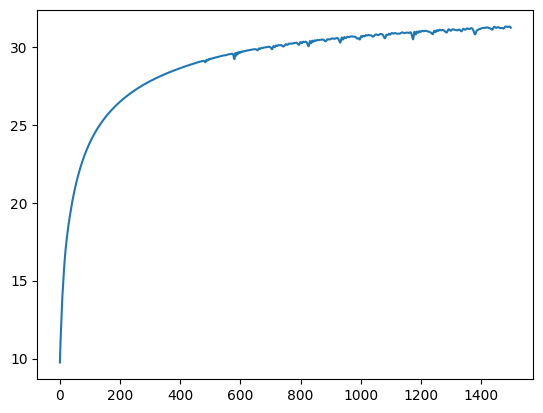

Fraction of trainable parameters of the model over the signal size: 0.3755989074707031


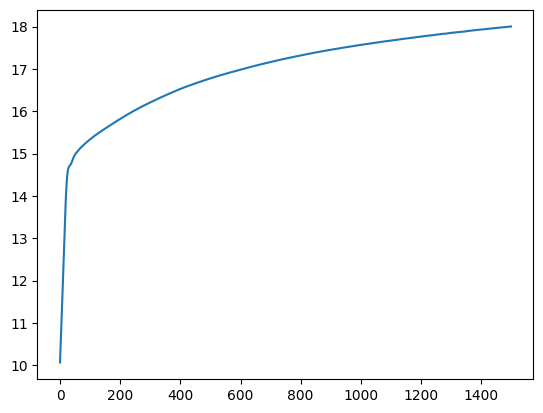

Fraction of trainable parameters of the model over the signal size: 0.3735389709472656


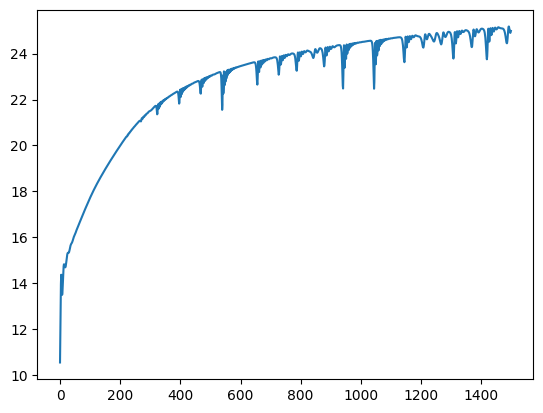

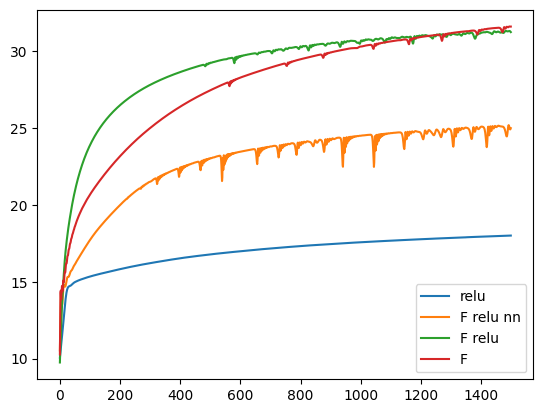

In [8]:
total_steps = 1500
run_example(filename="./00011_TE_1744x1160.png",
                outfilename="chili512",
                width=256,
                scale_lr = 0.5)

# Resolution experiment

Illustrating the impact of the scale parameter on the 1951 USAF resolution test chart. 

In [ ]:
#!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/fe/USAF-1951.svg/726px-USAF-1951.svg.png
# download the USAF test image
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/fe/USAF-1951.svg/454px-USAF-1951.svg.png
!wget http://www.bealecorner.org/red/test-patterns/star-chart-bars144-600dpi.png

--2023-07-22 21:42:39--  https://upload.wikimedia.org/wikipedia/commons/thumb/f/fe/USAF-1951.svg/454px-USAF-1951.svg.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13483 (13K) [image/png]
Saving to: ‘454px-USAF-1951.svg.png.1’

454px-USAF-1951.svg 100%[===================>]  13.17K  --.-KB/s    in 0s      

2023-07-22 21:42:39 (264 MB/s) - ‘454px-USAF-1951.svg.png.1’ saved [13483/13483]

--2023-07-22 21:42:40--  http://www.bealecorner.org/red/test-patterns/star-chart-bars144-600dpi.png
Resolving www.bealecorner.org (www.bealecorner.org)... 66.96.149.1
Connecting to www.bealecorner.org (www.bealecorner.org)|66.96.149.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1527926 (1.5M) [image/png]
Saving to: ‘star-chart-bars144-600dpi.png’

star-chart-bars144- 100%[=======

/tmp/ipykernel_1318101/4156566358.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = Image.fromarray(imageio.imread("star-chart-bars144-600dpi.png"))


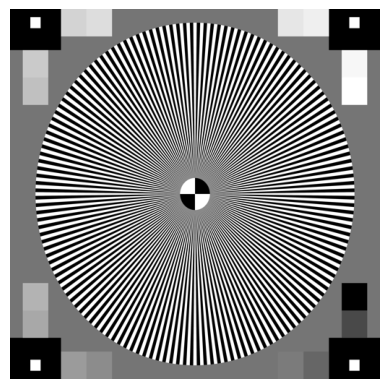

Fraction of trainable parameters of the model over the signal size: 1.5019569396972656


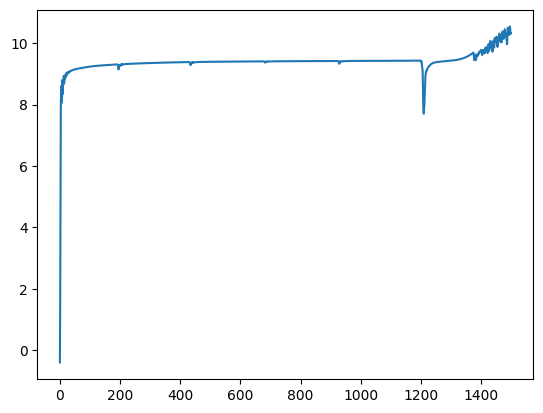

4.0 0.000244140625


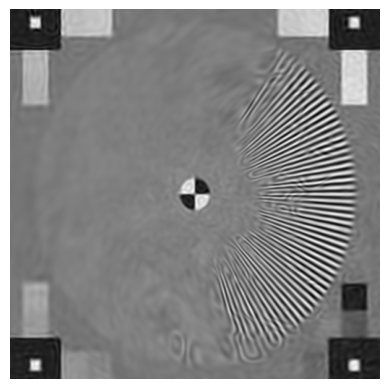

Fraction of trainable parameters of the model over the signal size: 1.5019569396972656


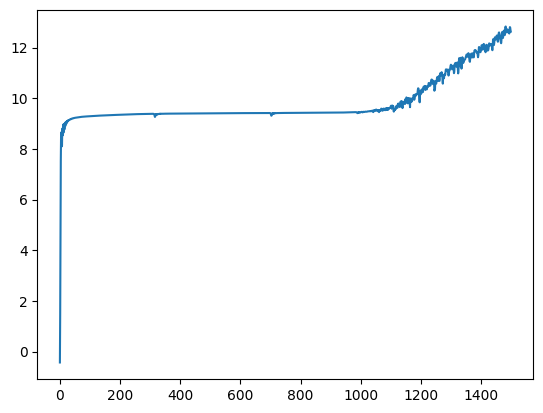

6.0 0.00054931640625


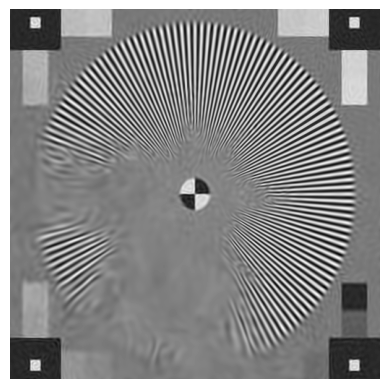

Fraction of trainable parameters of the model over the signal size: 1.5019569396972656


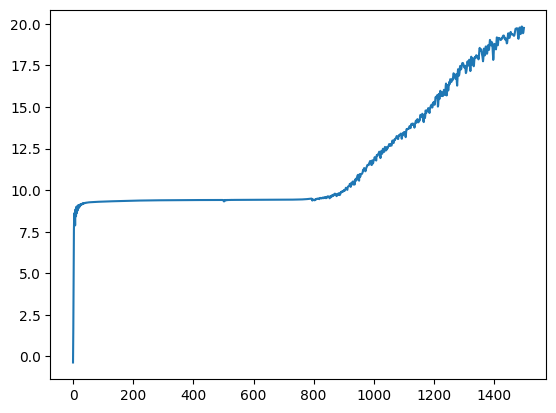

8.0 0.0009765625


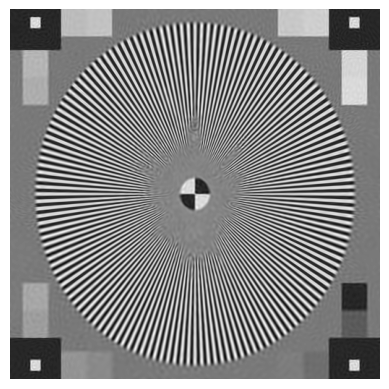

Fraction of trainable parameters of the model over the signal size: 1.5019569396972656


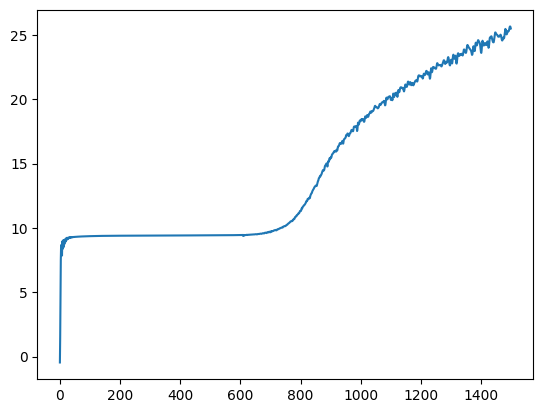

12.0 0.002197265625


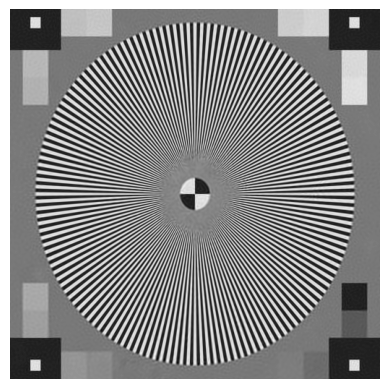

Fraction of trainable parameters of the model over the signal size: 1.5019569396972656


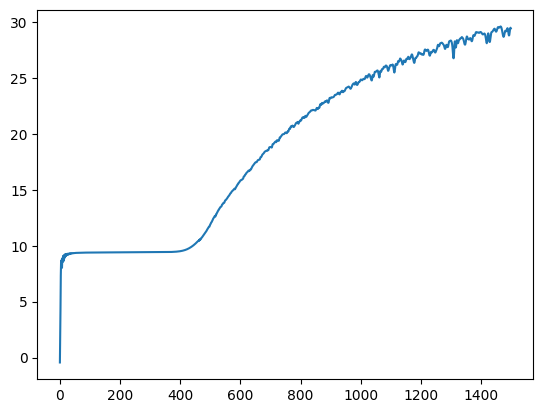

16.0 0.00390625


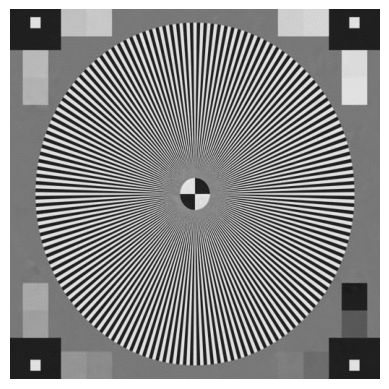

Fraction of trainable parameters of the model over the signal size: 1.5019569396972656


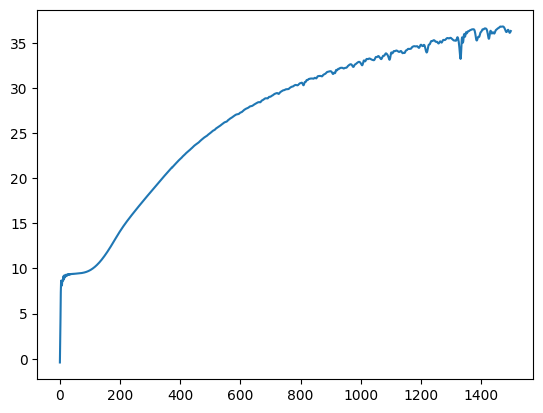

32.0 0.015625


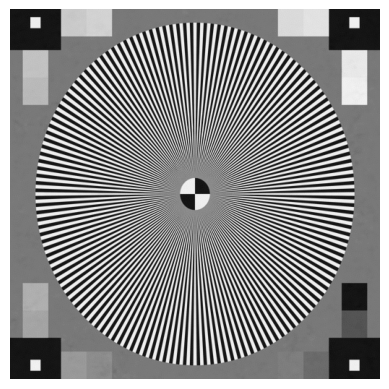

Fraction of trainable parameters of the model over the signal size: 1.5019569396972656


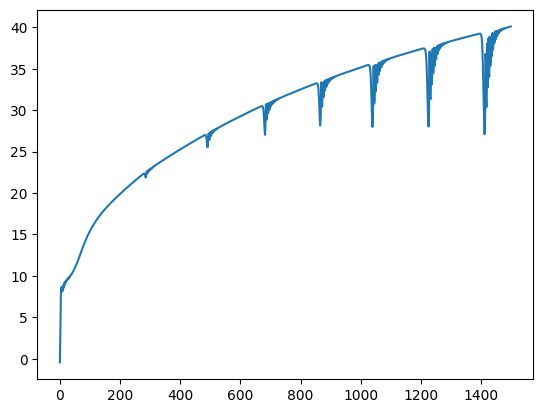

64.0 0.0625


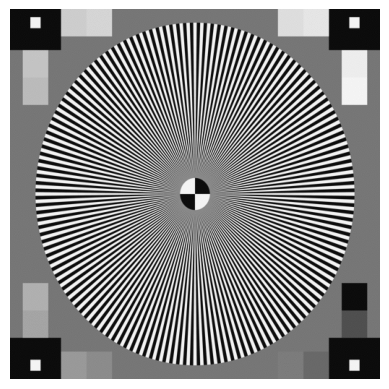

In [9]:
## USAF test Image 
# comment the following out to work with the USAF test image
#img = Image.fromarray(imageio.imread("./454px-USAF-1951.svg.png"))
#_ , img = img.split()
#img_width, img_height = img.size
#transformimg = Compose([ToTensor(),Normalize(torch.Tensor([-0.5]), torch.Tensor([0.5])), ])
#img_tensor = transformimg(img)

## Star chart test Image
img = Image.fromarray(imageio.imread("star-chart-bars144-600dpi.png"))
img = img.resize((512,512))
img_width, img_height = img.size
transformimg = Compose([ToTensor(),Normalize(torch.Tensor([-0.5]), torch.Tensor([0.5])), CenterCrop(img_width), ])
img_tensor = transformimg(img)


img_rep = ImageFitting(img_tensor)
    
dataloader = DataLoader(img_rep, batch_size=1, pin_memory=True, num_workers=0)
model_input, signal = next(iter(dataloader))
model_input, signal = model_input.cuda(), signal.cuda()


# plot the original image
img = signal.cpu().view(img_height,img_width).detach().numpy()
plt.imshow( img ,cmap='gray')
plt.axis('off')
plt.savefig("USAF_orig.png", bbox_inches='tight')
plt.show()

width = 512
for scale in [4.0,6.0,8.0,12.0,16.0,32.0,64.0]:
    total_steps = 1500
    model = FMLP(in_features=2,out_features=1,hidden_layers=3,width=width,scale=scale).cuda()
    fmlp_psnrs,img_fmlp = run_exp(signal,model_input,model,total_steps=total_steps,lr=3e-2,img_width=img_width,img_height=img_height)

    factor = 0.5*( 1.0*scale*(2/img_width) )**2
    print(scale, factor)
    #plt.title("scale = "+str(scale))
    plt.imshow( img_fmlp ,cmap='gray')
    plt.axis('off')
    plt.savefig("USAF"+str(scale)+".png", bbox_inches='tight')
    plt.show()
